In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [38]:
words = open("names.txt", "r").read().splitlines()
words[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [39]:
unique_chars = set("".join(list(word for word in words)))
mp = {ch:indx + 1 for indx, ch in enumerate(sorted(unique_chars))}
mp["."] = 0
mp_rev = {indx: ch for ch, indx in mp.items()}
print(mp_rev[0])

.


In [40]:
# Prepare data
xs, ys = [], []
block_size=3
emb_dim = 10
for word in words:
    context = [0] * block_size
    for ch in word+".":
        xs.append(context)
        ys.append(mp[ch])
        # print("".join([mp_rev[con] for con in context]), "=>", ch)
        context = context[1:]
        context.append(mp[ch])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [266]:
# Create embeddings vector
all_emb = torch.randn((27, emb_dim))
emb = all_emb[xs]
emb.shape

torch.Size([228146, 6, 50])

In [267]:
# Initialize weights and biases for first hidden layer
W1 = torch.randn((emb_dim*block_size, 200))
b1 = torch.randn(200)
W1.shape
emb.shape

torch.Size([228146, 6, 50])

In [268]:
# forward propagation for the first layer
h1 = torch.tanh(emb.view(xs.shape[0], emb_dim*block_size) @ W1 + b1)
h1.shape

torch.Size([228146, 200])

In [269]:
# Intialize weights and biases for the final layer
W2 = torch.randn((200, 27))
b2 = torch.randn(27)

In [270]:
# forward propagation for the final layer
logits = h1@ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True) # Softmax (first exp and then divide with all exp sum of that row)
probs.shape

torch.Size([228146, 27])

In [271]:
# Find loss by fetching proper probabilites and calculating maximum log likelihood
itera = torch.arange(xs.shape[0])
logloss = -probs[itera, ys].log().mean()
logloss.item()

35.700740814208984

In [272]:
# Another way of finding logloss which is more efficient and must be used everywhere instead of the above manual approach
# Look the value is the exact same as we find above
# Advantage of this approach is computationally efficient as larger values of exponent do not explode
# Efficient during forward and backward propagation as calculations are done in a cluster way instead of multiple steps in our approach
loss = F.cross_entropy(logits, ys)
loss.item()

35.70074462890625

In [336]:
all_emb = torch.randn((27, emb_dim))
W1 = torch.randn((emb_dim * block_size, 200)) * 0.1
b1 = torch.randn(200) * 0
W2 = torch.randn(200, 27) * 0.01 # have to multiply with a very small number so that logits are nealry 0 bcoz initially at iter 1 
# all chars should have same prob
# Also if initialized with small value, at intial few iterations our model will not spend too much time to minimize initial garbaze loss
b2 = torch.randn(27) * 0
all_parameters = [W1, W2, b1, b2, all_emb]
for param in all_parameters:
    param.requires_grad = True

In [148]:
# Putting it alltogether
for i in range(10):
    # forward pass
    h1 = torch.tanh(all_emb[xs].view(xs.shape[0], 6) @ W1 + b1)
    logits = h1@ W2 + b2
    # Calculate loss
    loss = F.cross_entropy(logits, ys)
    # Reseting grads
    for param in all_parameters:
        param.grad = None
    # Backward pass
    loss.backward()
    # Updating gradients
    lr = 0.1
    for param in all_parameters:
        param.data -= lr * param.grad
    print(loss.item())

17.362211227416992
16.132671356201172
15.045320510864258
14.105276107788086
13.237545013427734
12.465215682983398
11.788536071777344
11.17415714263916
10.600360870361328
10.06256103515625


In [158]:
indxs = torch.randint(0, xs.shape[0], (32,))
all_emb[xs][indxs].shape

torch.Size([32, 3, 2])

In [311]:
# Training seems slow. Apply mini batch gradient descent
# Putting it alltogether
batch_size = 32
for i in range(1000):
    # Create batch
    indxs = torch.randint(0, xs.shape[0], (batch_size,))
    # forward pass
    h1 = torch.tanh(all_emb[xs][indxs].view(-1, emb_dim * block_size) @ W1 + b1)
    logits = h1@ W2 + b2
    # Calculate loss
    loss = F.cross_entropy(logits, ys[indxs])
    # Reseting grads
    for param in all_parameters:
        param.grad = None
    # Backward pass
    loss.backward()
    # Updating gradients
    # Found this learning rate best possible by approach below
    lr = 0.1
    for param in all_parameters:
        param.data -= lr * param.grad
    print(loss.item())

3.2804553508758545
3.22396183013916
3.2306153774261475
3.3272457122802734
3.226907730102539
3.1467576026916504
3.0715832710266113
3.0777881145477295
2.90610933303833
2.9368410110473633
3.270831823348999
2.9315319061279297
2.957568883895874
2.860412120819092
2.8690576553344727
2.994201421737671
2.985551118850708
2.8507635593414307
2.595991373062134
2.6554062366485596
2.8817687034606934
2.856881856918335
2.4764015674591064
2.8853957653045654
3.021165370941162
2.872558355331421
2.5105395317077637
2.7911245822906494
2.694685935974121
2.39603853225708
2.641472339630127
3.020416736602783
2.948867082595825
2.5409374237060547
2.635939836502075
2.8073060512542725
2.4404706954956055
2.5376851558685303
2.7495968341827393
2.4862942695617676
2.976794958114624
2.549273729324341
2.823073625564575
2.5804381370544434
2.7441952228546143
2.689441204071045
2.6601312160491943
2.589704990386963
2.8101205825805664
2.4499504566192627
2.7057747840881348
2.3085427284240723
2.3694443702697754
2.6644299030303955


In [176]:
# How to pick up a learning rate 


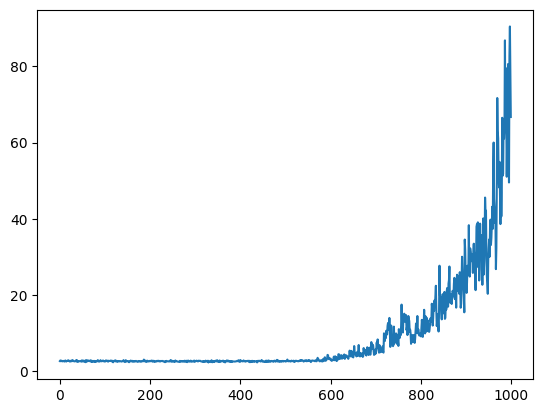

In [300]:
lrs = torch.linspace(-3, 1, 1000)
lrates, losses = [], []
for i in range(1000):
    # Create batch
    indxs = torch.randint(0, xs.shape[0], (128,))
    # forward pass
    h1 = torch.tanh(all_emb[xs][indxs].view(-1, emb_dim * block_size) @ W1 + b1)
    logits = h1@ W2 + b2
    # Calculate loss
    loss = F.cross_entropy(logits, ys[indxs])
    # Reseting grads
    for param in all_parameters:
        param.grad = None
    # Backward pass
    loss.backward()
    # Updating gradients
    lr = 10 ** lrs[i]
    for param in all_parameters:
        param.data -= lr * param.grad
    lrates.append(i)
    losses.append(loss.item())
plt.plot(lrates, losses)


In [294]:
min_index = losses.index(min(losses))
print(min_index, lrs[min_index])

504 tensor(-0.9820)


In [41]:
# Divide datasets into train, test, validation set
# Use train set to train the model
# Use validation set to tune hyperparameters (Number of neurons in hidden layers, embed dimention, learning rate, increase block size)
# Use test set to see the final loss

len_train = int(0.8 * xs.shape[0])
validation_end= int(0.9 * xs.shape[0])
xs_train, ys_train = xs[:len_train], ys[:len_train]
xs_val, ys_val = xs[len_train:validation_end], ys[len_train:validation_end]
xs_test, ys_test = xs[validation_end:], ys[validation_end:]
print(len(xs_train) + len(xs_val) + len(xs_test), len(xs))

228146 228146


In [377]:
n_hidden = 200
all_emb = torch.randn((27, emb_dim))
W1 = torch.randn((emb_dim * block_size, n_hidden)) * 0.2 # Standard way to come up with this number is 1/fan_in ** 0.5
# So it should be
W1 = torch.randn((emb_dim * block_size, n_hidden)) * (1/(emb_dim * block_size) ** 0.5)
#b1 = torch.randn(n_hidden) * 0.1  
W2 = torch.randn(n_hidden, 27) * 0.01 # have to multiply with a very small number so that logits are nealry 0 bcoz initially at iter 1 
# all chars should have same prob
# Also if initialized with small value, at intial few iterations our model will not spend too much time to minimize initial garbaze loss
b2 = torch.randn(27) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) # It is important to be exact gaussian at iteration 1 as it will use most of our neurons with any activation function
all_parameters = [W1, W2, b2, all_emb, bngain, bnbias]
for param in all_parameters:
    param.requires_grad = True

In [378]:
h1, pretain = None, None
for i in range(1000):
    # Create batch
    indxs = torch.randint(0, xs_train.shape[0], (batch_size,))
    # forward pass
    pretain = all_emb[xs_train][indxs].view(-1, emb_dim * block_size) @ W1 #+   b1     # Why applying batch normalization this bias will not 
    # have effect at all 
    # because
    # Imagine everyone in a room gets 5 bonus points on their test.
    # Then the teacher centers the scores by subtracting the class average.
    # The 5 bonus points? Completely erased by the normalization. Everyone’s relative score stays the same.
    # When applying batch norm previous linear layer do not need additional bias bnbias will work as a bias for this layer
    # Batch normalization
    pretain = (pretain - pretain.mean(0, keepdims=True)) / pretain.std(0, keepdims=True) # + epsilon to avoid divide by zero problem
    # We want pretain to be gaussian on initialization but not thoughout the training. We have to provide some flexibility to move this pretain
    pretain = bngain * pretain + bnbias
    # When applying batch normalization - now we are using batch std and batch mean but previously all were related to individual example
    # As batch are selected randomly this creates a noise in the output of the neurons which previously not exist
    # But this surprisingly act as a regularizer and prevents model to be overfitted
    h1 = torch.tanh(pretain)
    logits = h1@ W2 + b2
    # Calculate loss
    loss = F.cross_entropy(logits, ys_train[indxs])
    # Reseting grads
    for param in all_parameters:
        param.grad = None
    # Backward pass
    loss.backward()
    # Updating gradients
    # Found this learning rate best possible by approach below
    lr = 0.0591
    for param in all_parameters:
        param.data -= lr * param.grad
    if i > 950:
        print(loss.item())
    # plt.hist(h1.view(-1).tolist(), 50)
    # print(h1.shape)
    # if i > 2: 
    #     break


2.647988796234131
2.206835985183716
2.4092259407043457
2.4273533821105957
2.3906795978546143
2.3629097938537598
2.2068583965301514
2.5580742359161377
2.1198954582214355
2.4873299598693848
2.4174983501434326
2.432103157043457
2.5299904346466064
2.4491794109344482
2.2831315994262695
2.587496757507324
2.157932758331299
2.416187047958374
2.3969404697418213
2.468878984451294
2.128460645675659
2.8513455390930176
2.671748399734497
2.7146103382110596
2.1556107997894287
2.4716386795043945
2.4209470748901367
2.294201612472534
2.5167551040649414
2.526135206222534
2.228742837905884
2.4635775089263916
2.6517608165740967
2.4726576805114746
2.325174570083618
2.516587734222412
2.5301647186279297
2.194117307662964
2.6680285930633545
2.547513484954834
2.161362409591675
2.673553466796875
2.5599281787872314
2.5816092491149902
2.1290080547332764
2.614030361175537
2.404470443725586
1.9111238718032837
2.3428235054016113


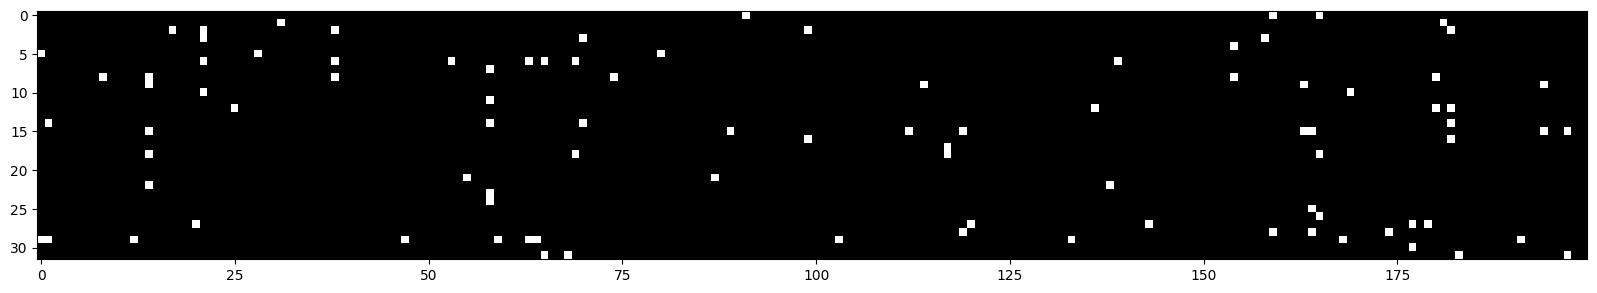

In [346]:
plt.figure(figsize=(20, 10))
plt.imshow(h1.abs() > 0.99, cmap='gray',  interpolation='nearest')
# this is output of 200 neurons. If any column is completely white then that will be a dead neuron and will never learn
# white means true and black means false
# Why most of the values are -1 and 1 its because see the following distribution of pretain which is very wide -15 to 15

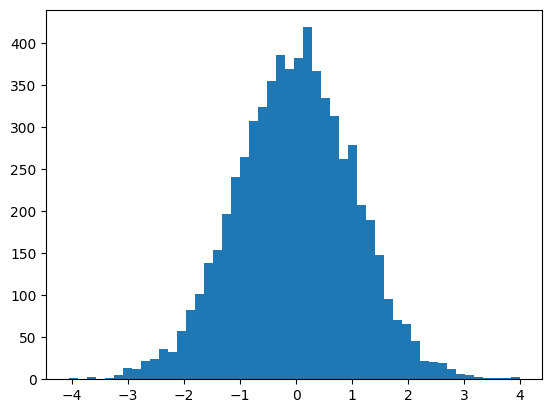

In [347]:
plt.hist(pretain.view(-1).tolist(), 50)
plt.show()

In [ ]:
# In order to reduce width of pretain we have to change W1 and b1 and make them closer to 0


In [358]:
# During validtion or test we do not have batch. So what will be our mean and std values ? 
# We will calculate ultimate mean and std after all training finishes and use values while evaluating a single example
with torch.no_grad():
    pretain = all_emb[xs].view(all_emb[xs].shape[0], -1) @ W1 + b1
    trained_mean = pretain.mean(0, keepdims=True)
    trained_std = pretain.std(0, keepdims=True)

In [359]:
# Find loss on validation set
@torch.no_grad()
def getLossOnValSet():
    pretain = all_emb[xs_val].view(-1, emb_dim * block_size) @ W1 + b1
    # Batch normalization
    pretain = (pretain - trained_mean) / trained_std
    # We want pretain to be gaussian on initialization but not thoughout the training. We have to provide some flexibility to move this pretain
    pretain = bngain * pretain + bnbias
    h1 = torch.tanh(pretain)
    logits = h1@ W2 + b2
    # Calculate loss
    loss = F.cross_entropy(logits, ys_val)
    print(loss.item())
getLossOnValSet()

2.5882842540740967


In [360]:
# Find loss on train set
@torch.no_grad()
def getLossOnTrainSet():
    pretain = all_emb[xs_train].view(-1, emb_dim * block_size) @ W1 + b1
    # Batch normalization
    pretain = (pretain - trained_mean) / trained_std
    # We want pretain to be gaussian on initialization but not thoughout the training. We have to provide some flexibility to move this pretain
    pretain = bngain * pretain + bnbias
    h1 = torch.tanh(pretain)
    logits = h1@ W2 + b2
    # Calculate loss
    loss = F.cross_entropy(logits, ys_train)
    print(loss.item())
getLossOnTrainSet()

2.3925132751464844


In [312]:
# Find out first n prediction
@torch.no_grad()
def predict_n_names(nn):
    context = [0] * block_size
    for _ in range(nn):
        context = [0] * block_size
        out = ""
        while True:
            h1 = torch.tanh(all_emb[context].view(1, emb_dim * block_size) @ W1 + b1)
            logits = h1 @ W2 + b2
            probs = F.softmax(logits, dim=1)
            idx = torch.multinomial(input=probs, num_samples=1, replacement=True).item()
            if idx == 0:
                break
            out += mp_rev[idx]
            context = context[1:] + [idx]
        print(out)
predict_n_names(10)

wadmalakellaceraurmen
ject
facion
anis
elvhanl
wartracilesiimilayno
azina
ellayadesfe
mafanileyan
sulyahalynn


In [1]:
# Here is the updated oop approach

In [173]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features)) / (in_features ** 0.5)
        self.b = torch.zeros(out_features) if bias else None
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
class Tanh:
    def __call__(self, h):
        self.out = torch.tanh(h)
        return self.out
    def parameters(self):
        return []
class BatchNorm1D:
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # Trainable 
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # Non Trainanble
        self.running_var = torch.ones(num_features)
        self.running_mean = torch.zeros(num_features)
        self.training = True

    def __call__(self, x):
        curr_mean = x.mean(0, keepdims=True)
        curr_var = x.var(0, keepdims=True)
        out1 = None
        if self.training:
            out1 = (x - curr_mean) / torch.sqrt(curr_var + self.eps)
        else:
            out1 = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps) 
        self.out = self.gamma * out1 + self.beta
        if self.training:
            with torch.no_grad():
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * curr_var
                self.runnig_mean = (1 - self.momentum) * self.running_mean + self.momentum * curr_mean
        return self.out
                                      
    def parameters(self):
        return [self.gamma, self.beta]
    

In [174]:
# Initialize variables and declare model layers
emb_dim = 10
n_hidden = 100
block_size = 3
vocab_size = 27
all_emb = torch.randn((vocab_size, emb_dim))
# layers = [Linear(emb_dim * block_size, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, vocab_size)]

layers = [Linear(emb_dim * block_size, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          Linear(n_hidden, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          Linear(n_hidden, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          Linear(n_hidden, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          Linear(n_hidden, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          Linear(n_hidden, vocab_size, False), BatchNorm1D(num_features=vocab_size),]
# Turn on requires_grad value for all the parameters
parameters = [all_emb] + [parameter for layer in layers for parameter in layer.parameters()]
print(sum([p.nelement() for p in parameters]))
for parameter in parameters:
    parameter.requires_grad = True

47024


In [175]:
with torch.no_grad():
    # 1. Make last linear layer less confident so that initial spikes got cut off and model spend more time on minimizing actual loss
    # layers[-1].W *= 0.1
    layers[-1].gamma *= 0.1
    
    # 2. As we are using tanh and not using normalization we should use the scale factor 5/3 for all the linear layers followed by tanh layer so that
    # after applying tanh output remains gaussian distributed 
    
    for layer in layers[0:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

    

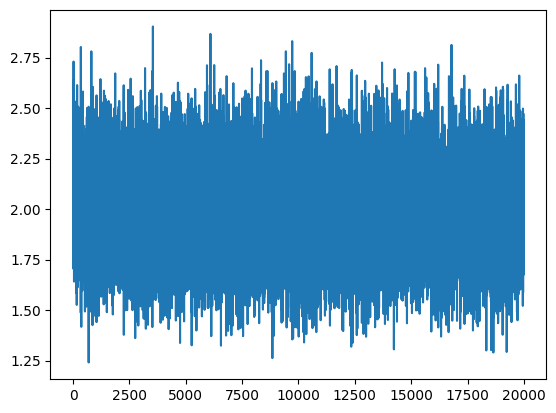

In [197]:

# Training loop 
max_iter = 20000
batch_size = 32
lr = 0.03
losses = []
ud = []
for i in range(max_iter):
    idx = torch.randint(0, xs_train.shape[0], (batch_size, ))
    emb = all_emb[xs_train[idx]]
    x = emb.view(batch_size, -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ys_train[idx])
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    losses.append(loss.item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
plt.plot(torch.arange(0, max_iter), losses)
plt.show()
# print(losses)

layer 2 (      Tanh): mean +0.01, std 0.77, saturated: 23.19%
layer 5 (      Tanh): mean -0.01, std 0.82, saturated: 34.44%
layer 8 (      Tanh): mean +0.02, std 0.84, saturated: 36.56%
layer 11 (      Tanh): mean -0.01, std 0.83, saturated: 35.88%
layer 14 (      Tanh): mean -0.02, std 0.83, saturated: 35.06%


Text(0.5, 1.0, 'activation distribution')

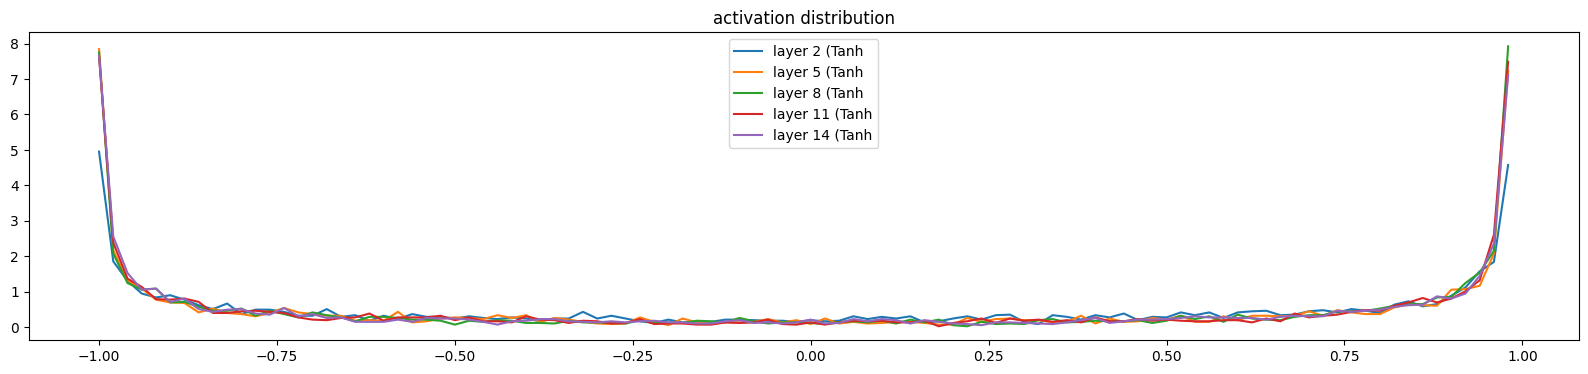

In [198]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000004, std 3.446131e-03
layer 5 (      Tanh): mean -0.000027, std 3.218105e-03
layer 8 (      Tanh): mean -0.000010, std 3.335714e-03
layer 11 (      Tanh): mean +0.000012, std 3.386564e-03
layer 14 (      Tanh): mean -0.000058, std 3.767554e-03


Text(0.5, 1.0, 'gradient distribution')

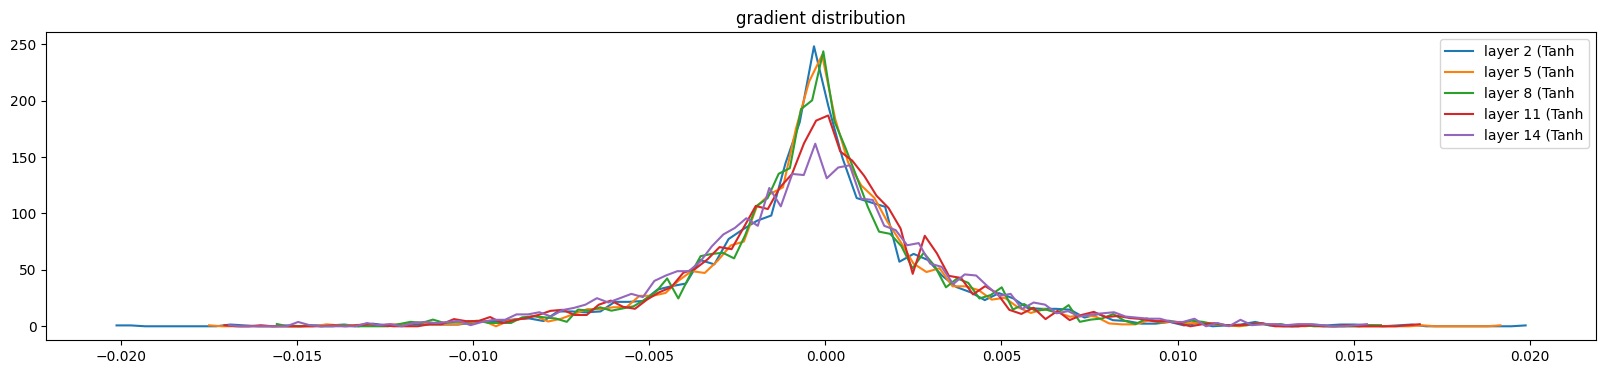

In [199]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

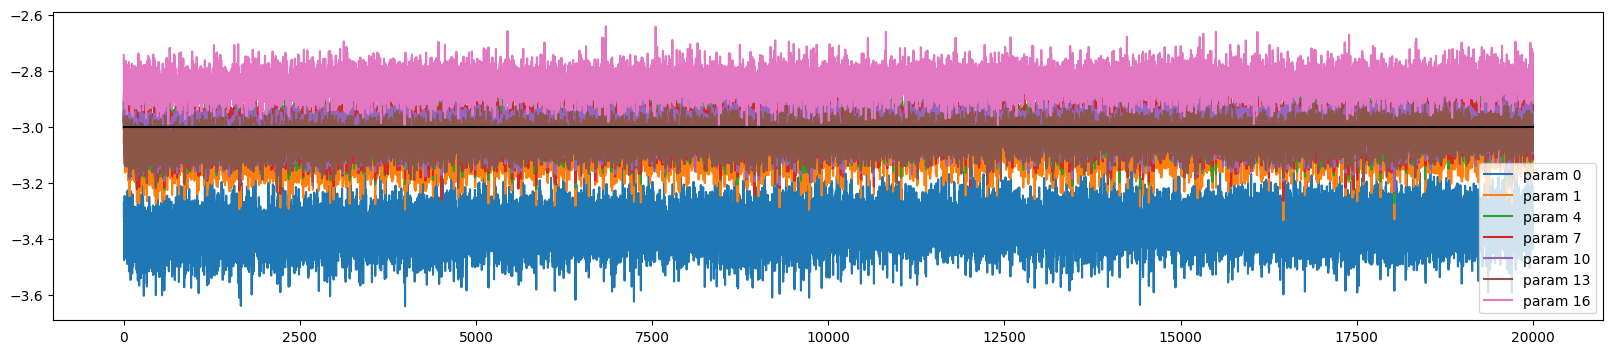

In [200]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [201]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xs_train, ys_train),
    'val': (xs_val, ys_val),
    'test': (xs_test, ys_test),
  }[split]
  emb = all_emb[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 1.9725494384765625
val 2.3237037658691406
test 2.360532760620117


In [181]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = all_emb[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(mp_rev[i] for i in out)) # decode and print the generated word

mri.
ammyanziee.
med.
ryll.
revmrstendrlen.
adelydiel.
izell.
jen.
edellennanarlelly.
mhlara.
nyshdrergshimie.
trin.
rondlen.
nopulyn.
breyven.
kylynn.
eksylah.
mys.
kyla.
hyl.


C:\Users\User\AppData\Local\Temp\ipykernel_13304\2442635405.py:33: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  curr_var = x.var(0, keepdims=True)
